In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Jason
!unzip '/content/drive/MyDrive/MDST - Dogs and Cats/Images.zip' -d 'train_data'

In [ ]:
import os
import sys
import keras
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.engine.training import Model
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Add, Dropout, Flatten, Dense, Activation

In [ ]:
import cv2
BASEPATH = '/content/train_data/Images'
LABELS = []
paths = []
for d in os.listdir(BASEPATH):
  if d == '.DS_Store': continue
  paths.append((BASEPATH + '/' + d, d))
  for c in os.listdir(BASEPATH + '/' + d):
    LABELS.append(c+d)
# resizing and converting to RGB
def load_and_preprocess_image(path):
  image = cv2.imread(path)
  image = cv2.resize(image, (180, 180))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

In [ ]:
X, y = [], []
temp = []
for path, label in paths:
  if path == "/content/train_data/Images/.DS_Store": continue
  label = label.split('-')[1]
  i = 252
  for image_path in os.listdir(path):
    image = load_and_preprocess_image(path + "/" + image_path)
    X.append(image)
    y.append(label)
    i = i-1
  while i > 0:
    image = load_and_preprocess_image(path + "/" + os.listdir(path)[i])
    rotate = tf.image.flip_left_right(image)
    X.append(rotate)
    y.append(label)
    i = i-1

In [ ]:
encoder = LabelBinarizer()
y = encoder.fit_transform(np.array(y))

In [ ]:
from sklearn.model_selection import train_test_split
X = np.array(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=87)

In [ ]:
from tensorflow.keras import datasets, layers, models

In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',
                   classes= 120,
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [ ]:
resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation= tf.keras.layers.PReLU()))
resnet_model.add(Dense(512, activation=tf.keras.layers.PReLU()))
resnet_model.add(layers.Dropout(0.35))
resnet_model.add(Dense(512, activation=tf.keras.layers.PReLU()))
resnet_model.add(layers.Dropout(0.35))
resnet_model.add(Dense(512, activation=tf.keras.layers.PReLU()))
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(Dense(120, activation='softmax'))

In [ ]:
resnet_model.summary()

In [ ]:
resnet_model.compile(optimizer='Adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])


history = resnet_model.fit(x_train, y_train,  validation_split = 0.2, epochs=20, batch_size = 64)

Epoch 1/20
284/284 [==============================] - 62s 182ms/step - loss: 4.0332 - accuracy: 0.0842 - val_loss: 2.6519 - val_accuracy: 0.2690
Epoch 2/20
284/284 [==============================] - 48s 169ms/step - loss: 2.7179 - accuracy: 0.2704 - val_loss: 2.1703 - val_accuracy: 0.3862
Epoch 3/20
284/284 [==============================] - 48s 170ms/step - loss: 2.2583 - accuracy: 0.3682 - val_loss: 1.8787 - val_accuracy: 0.4619
Epoch 4/20
284/284 [==============================] - 48s 169ms/step - loss: 1.9954 - accuracy: 0.4319 - val_loss: 1.7757 - val_accuracy: 0.4879
Epoch 5/20
284/284 [==============================] - 48s 170ms/step - loss: 1.7960 - accuracy: 0.4839 - val_loss: 1.7628 - val_accuracy: 0.5007
Epoch 6/20
284/284 [==============================] - 48s 170ms/step - loss: 1.6372 - accuracy: 0.5230 - val_loss: 1.7558 - val_accuracy: 0.5093
Epoch 7/20
284/284 [==============================] - 48s 169ms/step - loss: 1.5195 - accuracy: 0.5586 - val_loss: 1.6078 - val_ac

237/237 - 17s - loss: 1.8659 - accuracy: 0.6034 - 17s/epoch - 70ms/step


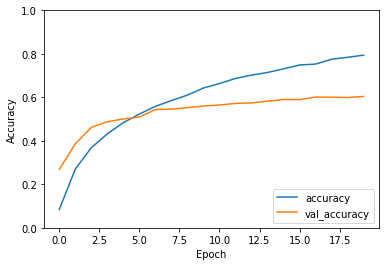

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = resnet_model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
predictions = resnet_model.predict(x_test)


237/237 [==============================] - 17s 68ms/step


In [ ]:
new= []
for i in predictions:
  temp = []
  max = i.max()
  for j in i:
    if j != max:
      temp.append(0)
    else:
      temp.append(1)
  new.append(temp)
new

In [ ]:
new[0]

In [ ]:
count = 0
sum = 0
breeds = []
test = []
for i in new:
  if (i == y_test[count]).all():
    sum = sum + 1
  else:
    breeds.append(y_test[count])
  test.append(y_test[count])
  count = count + 1
mean = sum/len(y_test)
print(mean)
final = encoder.inverse_transform(np.array(breeds))
final2 = encoder.inverse_transform(np.array(test))
rank = dict()
total = dict()
for i in final:
  if i not in rank:
    rank[i] = 1
  else:
    rank.update({i : rank.get(i) + 1})
print(rank)
for i in final2:
  if i not in total:
    total[i] = 1
  else:
    total.update({i : total.get(i) + 1})
print(total)
final3 = dict()
for i in rank:
  final3[i] = rank.get(i)/total.get(i)

print(final3)

In [ ]:
import operator
sorted = dict(sorted(final3.items(), key=operator.itemgetter(1),reverse=True))
print(sorted)

{'Shih': 0.896551724137931, 'toy_poodle': 0.7313432835820896, 'Airedale': 0.6811594202898551, 'malamute': 0.6774193548387096, 'Staffordshire_bullterrier': 0.6507936507936508, 'Rhodesian_ridgeback': 0.6349206349206349, 'Walker_hound': 0.631578947368421, 'collie': 0.6290322580645161, 'Italian_greyhound': 0.6, 'whippet': 0.5961538461538461, 'Brittany_spaniel': 0.5897435897435898, 'bloodhound': 0.5862068965517241, 'kelpie': 0.5849056603773585, 'Siberian_husky': 0.5740740740740741, 'Chihuahua': 0.5714285714285714, 'Saluki': 0.5671641791044776, 'Great_Pyrenees': 0.5657894736842105, 'Irish_wolfhound': 0.5614035087719298, 'Lhasa': 0.5555555555555556, 'Appenzeller': 0.546875, 'vizsla': 0.5441176470588235, 'giant_schnauzer': 0.5373134328358209, 'Weimaraner': 0.5294117647058824, 'Yorkshire_terrier': 0.5245901639344263, 'standard_poodle': 0.5245901639344263, 'miniature_schnauzer': 0.5217391304347826, 'Lakeland_terrier': 0.5147058823529411, 'standard_schnauzer': 0.5131578947368421, 'cairn': 0.50909

In [ ]:
sorted

{'Shih': 0.896551724137931,
 'toy_poodle': 0.7313432835820896,
 'Airedale': 0.6811594202898551,
 'malamute': 0.6774193548387096,
 'Staffordshire_bullterrier': 0.6507936507936508,
 'Rhodesian_ridgeback': 0.6349206349206349,
 'Walker_hound': 0.631578947368421,
 'collie': 0.6290322580645161,
 'Italian_greyhound': 0.6,
 'whippet': 0.5961538461538461,
 'Brittany_spaniel': 0.5897435897435898,
 'bloodhound': 0.5862068965517241,
 'kelpie': 0.5849056603773585,
 'Siberian_husky': 0.5740740740740741,
 'Chihuahua': 0.5714285714285714,
 'Saluki': 0.5671641791044776,
 'Great_Pyrenees': 0.5657894736842105,
 'Irish_wolfhound': 0.5614035087719298,
 'Lhasa': 0.5555555555555556,
 'Appenzeller': 0.546875,
 'vizsla': 0.5441176470588235,
 'giant_schnauzer': 0.5373134328358209,
 'Weimaraner': 0.5294117647058824,
 'Yorkshire_terrier': 0.5245901639344263,
 'standard_poodle': 0.5245901639344263,
 'miniature_schnauzer': 0.5217391304347826,
 'Lakeland_terrier': 0.5147058823529411,
 'standard_schnauzer': 0.5131578